<a href="https://colab.research.google.com/github/douglasmmachado/ExploratoryDataAnalysis/blob/master/Timeseries_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring the timeseries approach for the unified database

---



---



# Loading libs and database

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

raw_data_url ="https://raw.githubusercontent.com/douglasmmachado/ExploratoryDataAnalysis/master/project_database.csv"
df=pd.read_csv(raw_data_url, index_col=0)

categorical_features = ['ID_REF', 'ID_SITE_RATTACHE', 'CODE_ATC', 'HOSPI_CODE_UCD']
date_features = ['DATE_MOUV', 'WEEK', 'MONTH', 'YEAR']
numerical_features = ['N_UFS', 'QUANTITY', 'N_ETB', 'POPULATION', 'P_MEDICAL', 'PN_MEDICAL', 'LIT_HC', 'LIT_HP', 'SEJ_MCO', 'SEJ_HAD', 'SEJ_PSY', 'SEJ_SSR']

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75692 entries, 0 to 75691
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID_REF            75689 non-null  object 
 1   ID_SITE_RATTACHE  75690 non-null  object 
 2   CODE_ATC          75685 non-null  object 
 3   HOSPI_CODE_UCD    75690 non-null  object 
 4   DATE_MOUV         75685 non-null  object 
 5   N_UFS             75692 non-null  int64  
 6   QUANTITY          75685 non-null  float64
 7   WEEK              75685 non-null  float64
 8   MONTH             75692 non-null  int64  
 9   YEAR              75685 non-null  float64
 10  N_ETB             75692 non-null  int64  
 11  POPULATION        75692 non-null  float64
 12  P_MEDICAL         75692 non-null  int64  
 13  PN_MEDICAL        75692 non-null  int64  
 14  LIT_HC            75685 non-null  float64
 15  LIT_HP            75692 non-null  float64
 16  SEJ_MCO           75692 non-null  int64 

<ipython-input-67-af9092c990bd>:8: DtypeWarning: Columns (1,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv(raw_data_url, index_col=0)


# Data cleaning

In [69]:
df = df.drop_duplicates()
df = df.dropna()
df['DATE_MOUV'] = pd.to_datetime(df['DATE_MOUV'], 
               format='%Y-%m-%d')  # Changed the type of date too
               
for column in categorical_features:
  df[column] = df[column].astype('string')

# Changing the date display by year-month division
df['YEAR'] = df['YEAR'].astype(int).copy()
df['MONTH'] = df['MONTH'].astype(int).copy()

df.sample(5)

,ID_REF,ID_SITE_RATTACHE,CODE_ATC,HOSPI_CODE_UCD,DATE_MOUV,N_UFS,QUANTITY,WEEK,MONTH,YEAR,...,POPULATION,P_MEDICAL,PN_MEDICAL,LIT_HC,LIT_HP,SEJ_MCO,SEJ_HAD,SEJ_PSY,SEJ_SSR,SEJ_SLD
39820,507146,HOSPI_3,A12BA01,3400891225037,2015-04-17,6,340.0,16.0,4,2015,...,1120190.0,1239,7161,2053.0,493.0,118924,650,2878,1334,75
40080,507146,HOSPI_3,A12BA01,3400891225037,2016-05-02,4,180.0,18.0,5,2016,...,1132481.0,1290,7336,2030.0,506.0,120193,787,2755,1309,88
9340,890264,HOSPI_1,N02AX02,3400892729589,2015-06-12,5,150.0,24.0,6,2015,...,571879.0,684,5295,1411.0,94.0,74102,0,0,1140,57
72838,2431,HOSPI_4,N05BA12,3400892075761,2017-06-13,2,1500.0,24.0,6,2017,...,1843319.0,2556,15650,4500.0,467.0,254570,0,5,8464,285
4190,800851,HOSPI_1,B05XA03,3400892761527,2014-12-22,2,60.0,52.0,12,2014,...,571632.0,684,5321,1418.0,151.0,71879,0,0,1194,79


## Removing outliers by hospital and by drug

In [70]:
def remove_outliers(df, columns, verbose = False):
  N_macro = df.shape[0]
  print('N: ', N_macro)
  for col in columns:
      for id_ref in df['ID_REF'].unique():

          # Filter the dataframe for the specific ID_REF
          df_subset = df[df['ID_REF'] == id_ref]
          N = df_subset.shape[0]

          # Calculate statistics for the column within the ID_REF subset
          z_scores = np.abs(stats.zscore(df_subset[col]))
          threshold = 3

          # Remove outliers based on the z-score threshold within the ID_REF subset
          df_subset = df_subset[z_scores < threshold]
          N_new = df_subset.shape[0]
          delta = N - N_new

          # Update the original dataframe with the filtered values
          df = pd.concat([df[df['ID_REF'] != id_ref], df_subset])

          if verbose:
            if delta > 0:
                print(f'Column: {col}')
                print(f'ID_REF: {id_ref}')
                print(f'Removed outliers: {delta}')
                print(f'Removed percentage: {(100 * delta / N):.3}%')
                print()


  N_macro_new = df.shape[0]
  print('N_new: ', N_macro_new)
  delta = N_macro - N_macro_new
  print(f'Total removed outliers: {(100 * delta / N_macro):.3}%')
  return df

In [71]:
def visualize_distribution(df, features):
  '''
    Plot of distribution for the numerical features after removing the outliers
  '''

  fig, axes = plt.subplots(4, 3,sharex=False, figsize=(20,20))

  i = 0
  j = 0
  for column in features:
    sns.histplot(df[column], kde=True, stat="density", kde_kws=dict(cut=3),alpha=.4, edgecolor=(1, 1, 1, .4),ax=axes[i, j]).set(title='Distribution of: ' + str(column))
    if j == 2:
      i += 1
      j = 0
    else:
      j+=1

In [72]:
# Separating databases

n_medicines = df['ID_REF'].nunique()
print('Number of different medicines: ', n_medicines)

df_h1 = df[df["ID_SITE_RATTACHE"] == "HOSPI_1"]
df_h2 = df[df["ID_SITE_RATTACHE"] == "HOSPI_2"]
df_h3 = df[df["ID_SITE_RATTACHE"] == "HOSPI_3"]
df_h4 = df[df["ID_SITE_RATTACHE"] == "HOSPI_4"]


Number of different medicines:  84


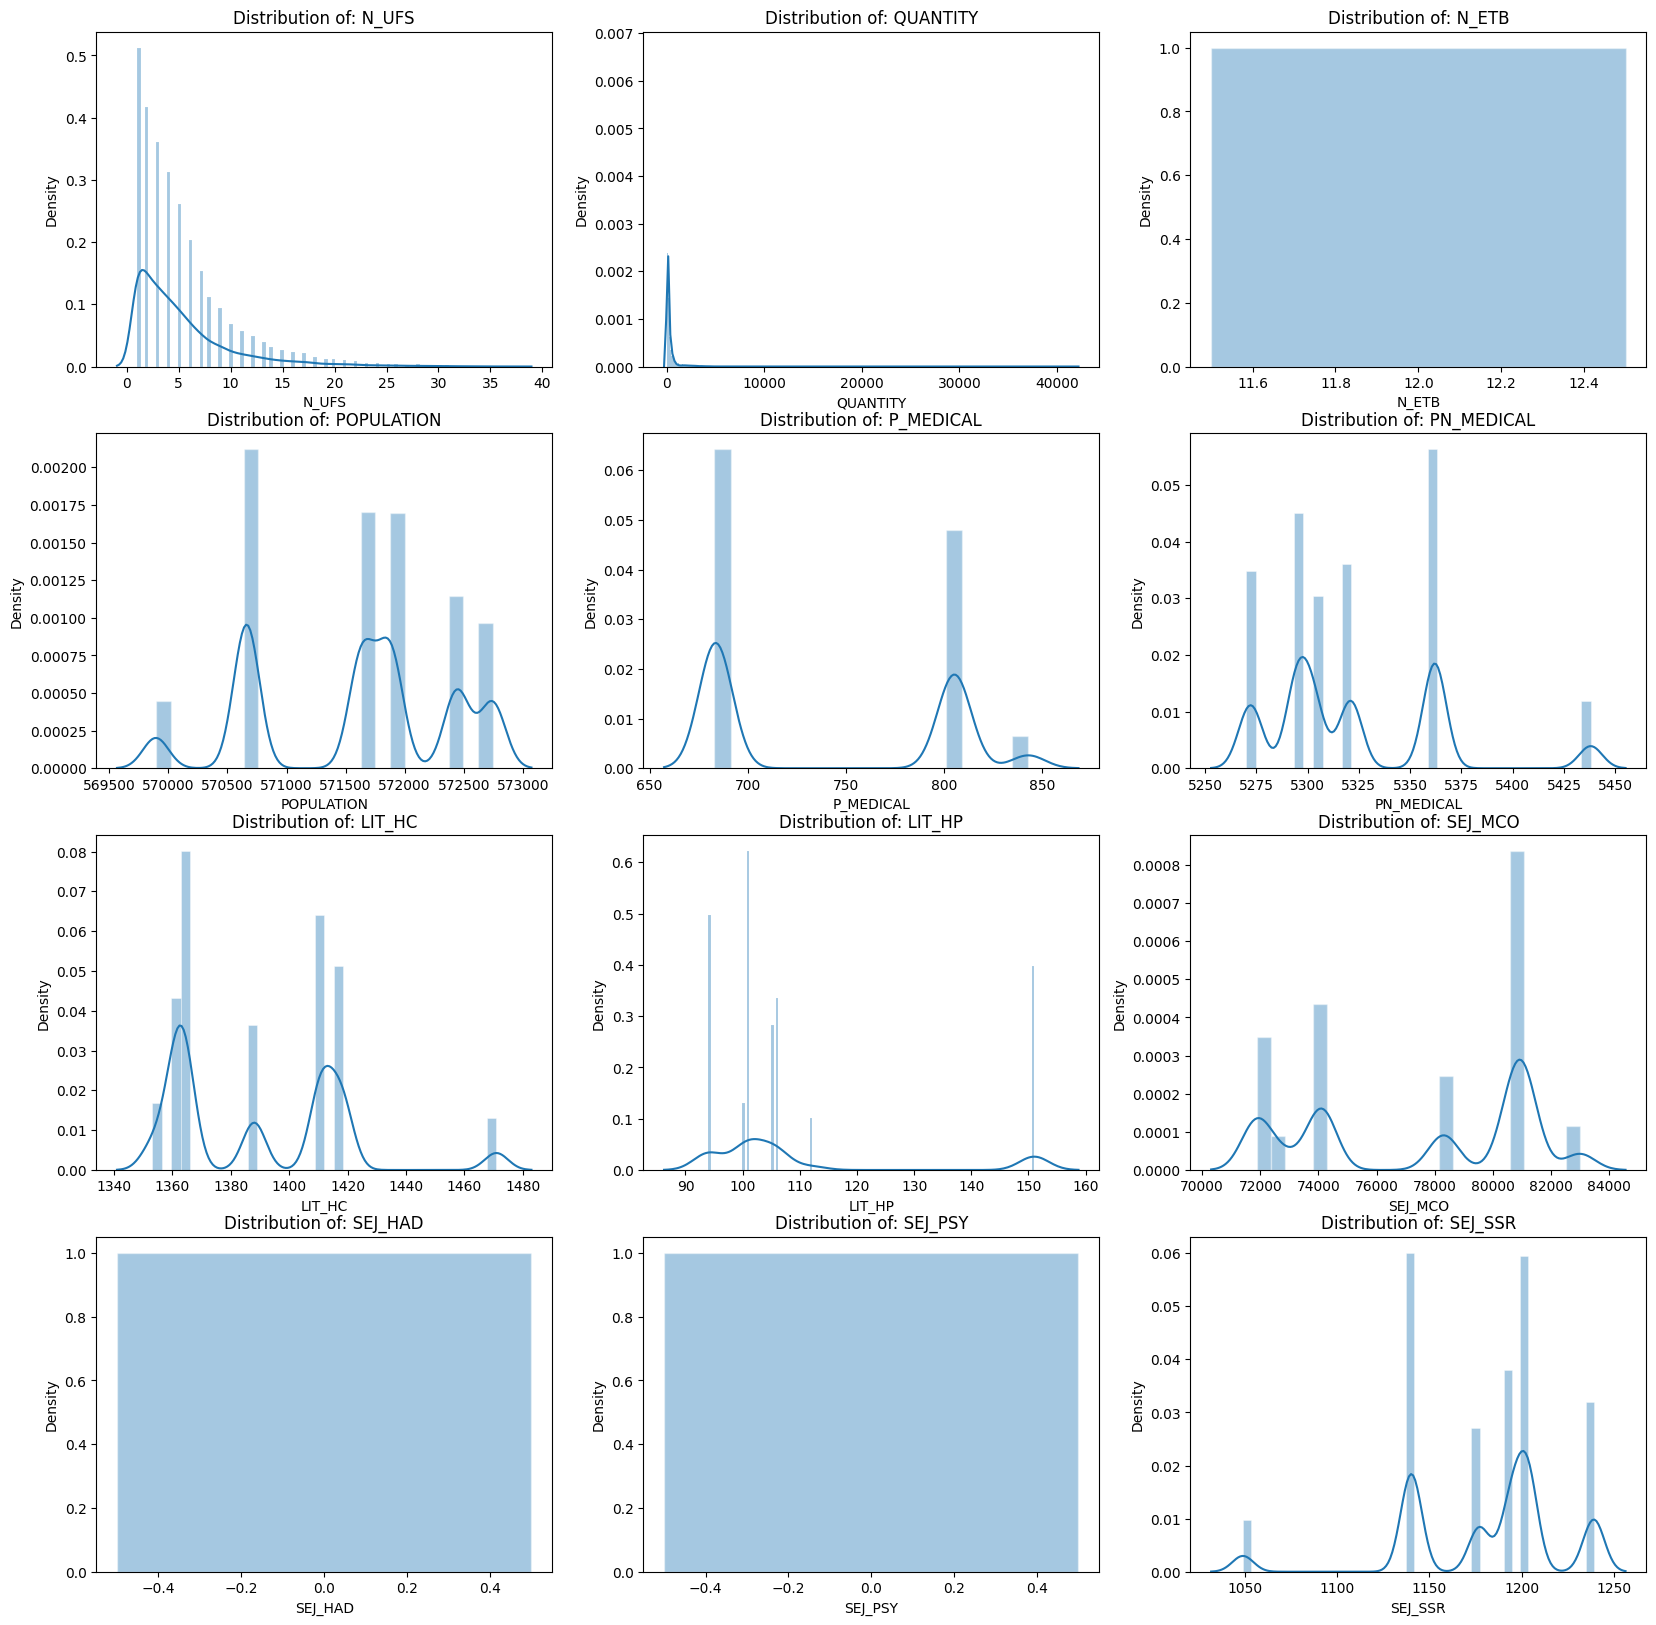

In [73]:
# Visualizing distribution before outlier removing
# Hospital 1
visualize_distribution(df_h1, numerical_features)

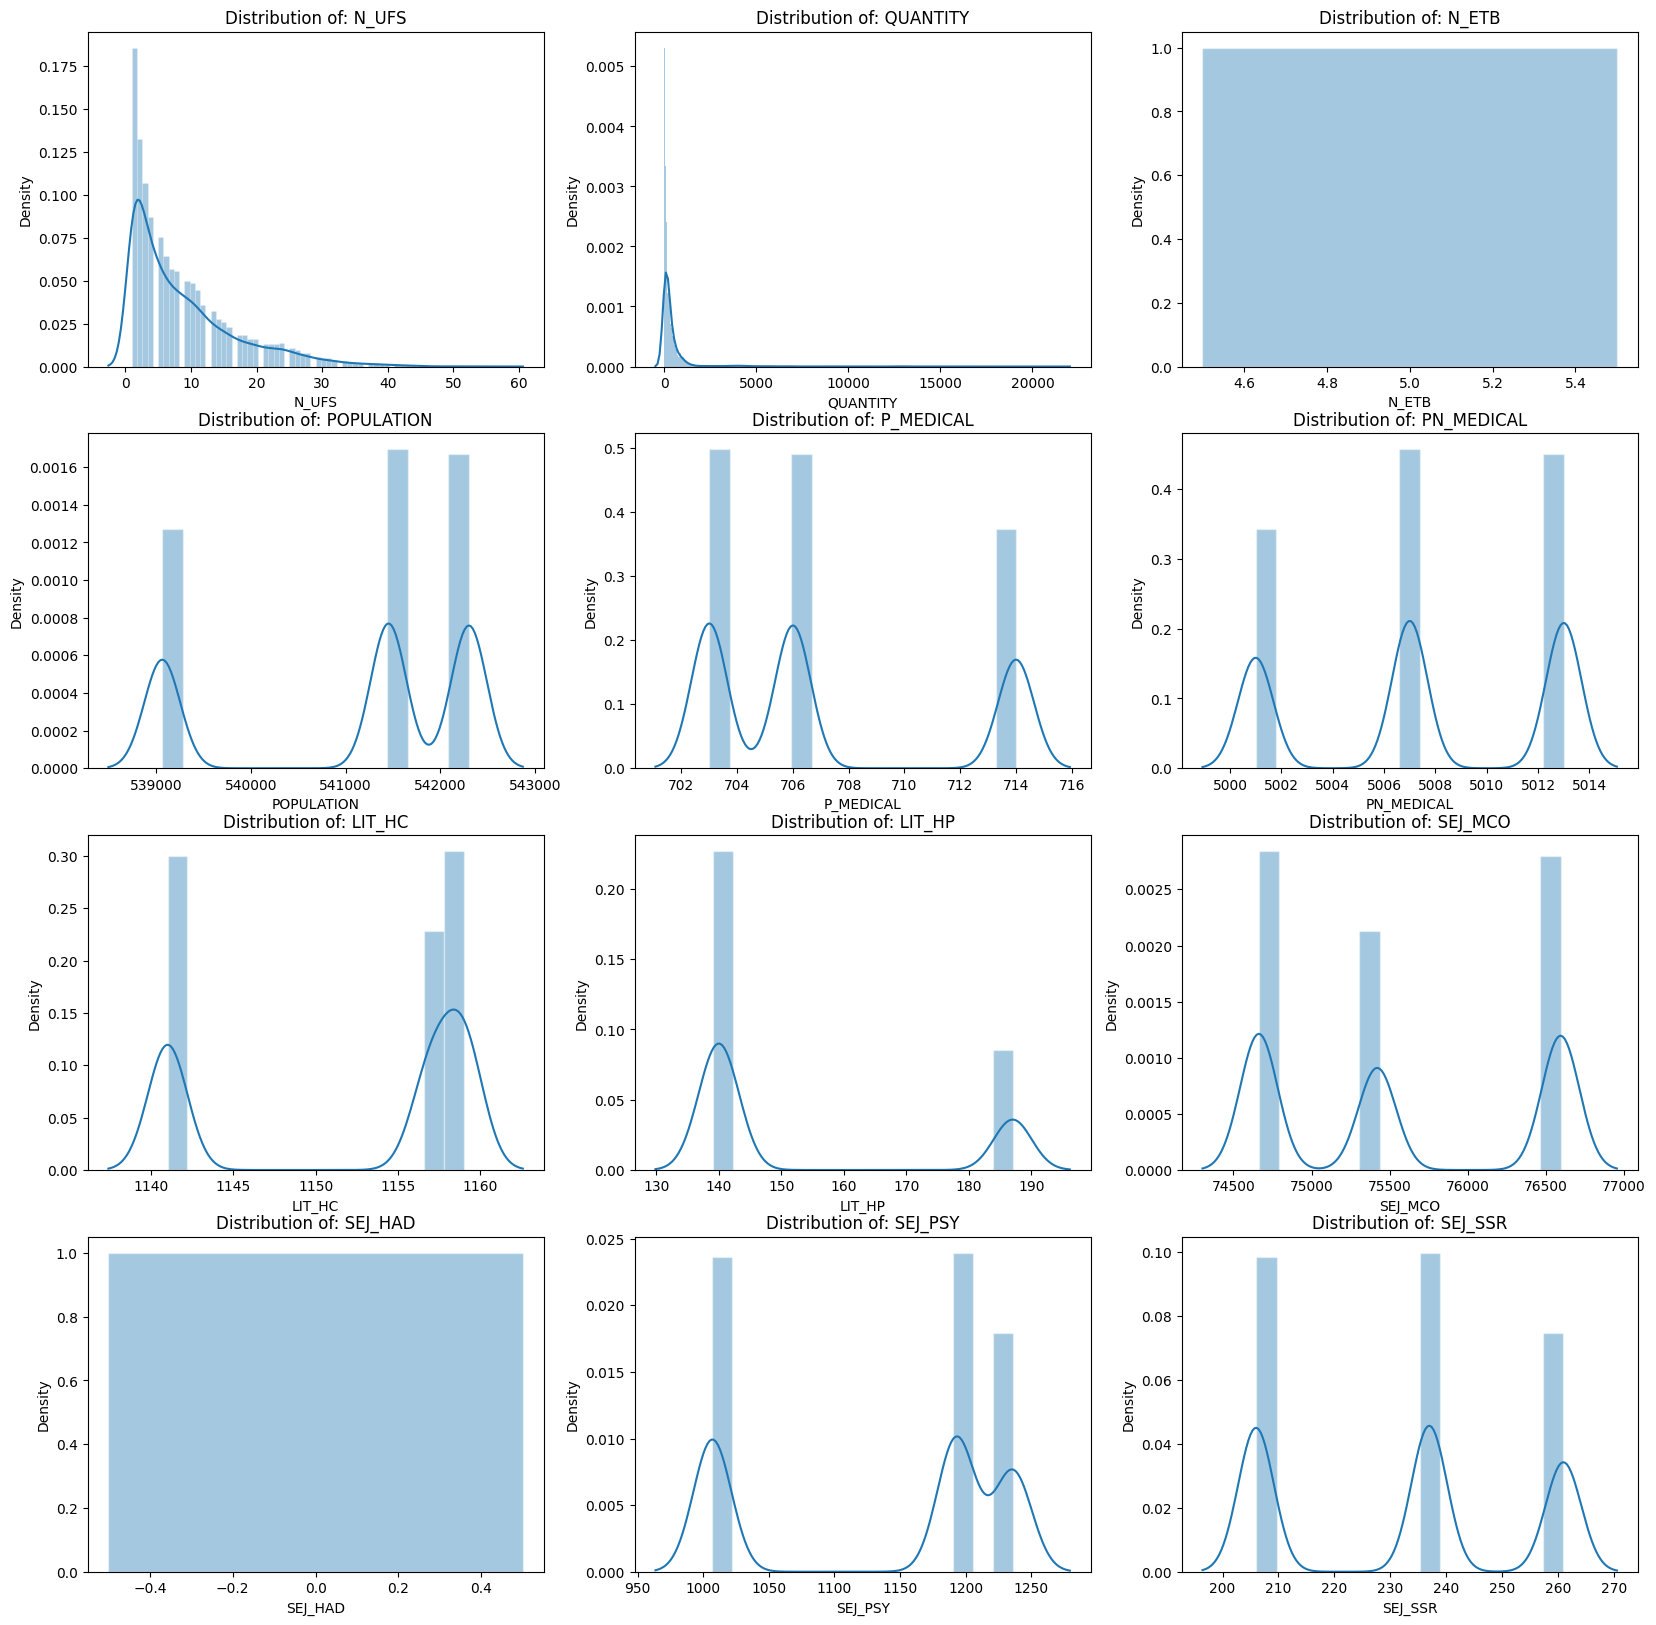

In [47]:
# Visualizing distribution before outlier removing
# Hospital 2
visualize_distribution(df_h2, numerical_features)

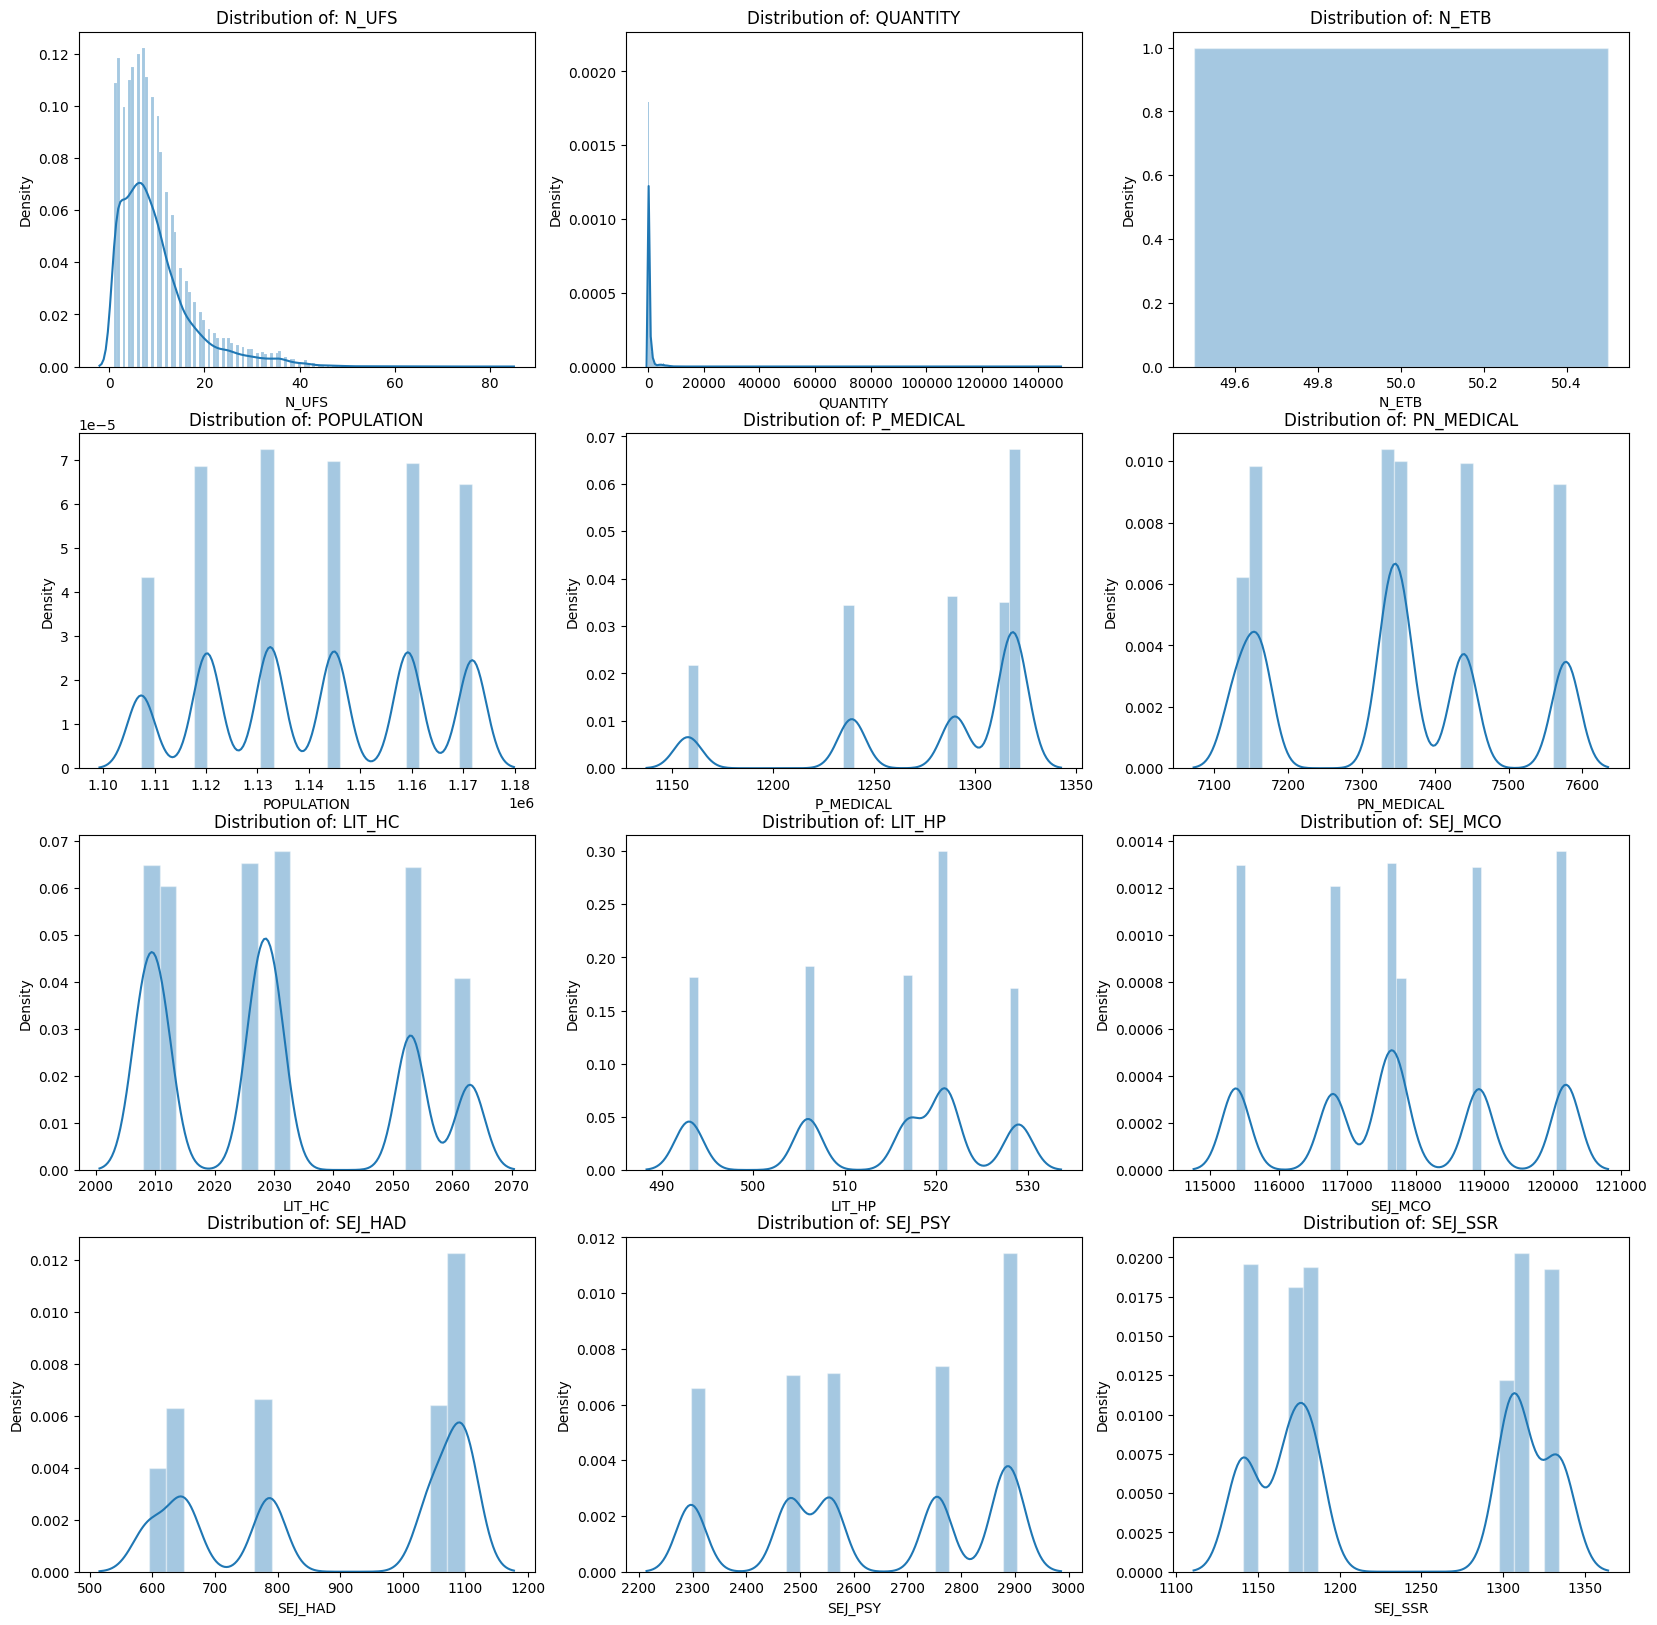

In [48]:
# Visualizing distribution before outlier removing
# Hospital 3
visualize_distribution(df_h3, numerical_features)

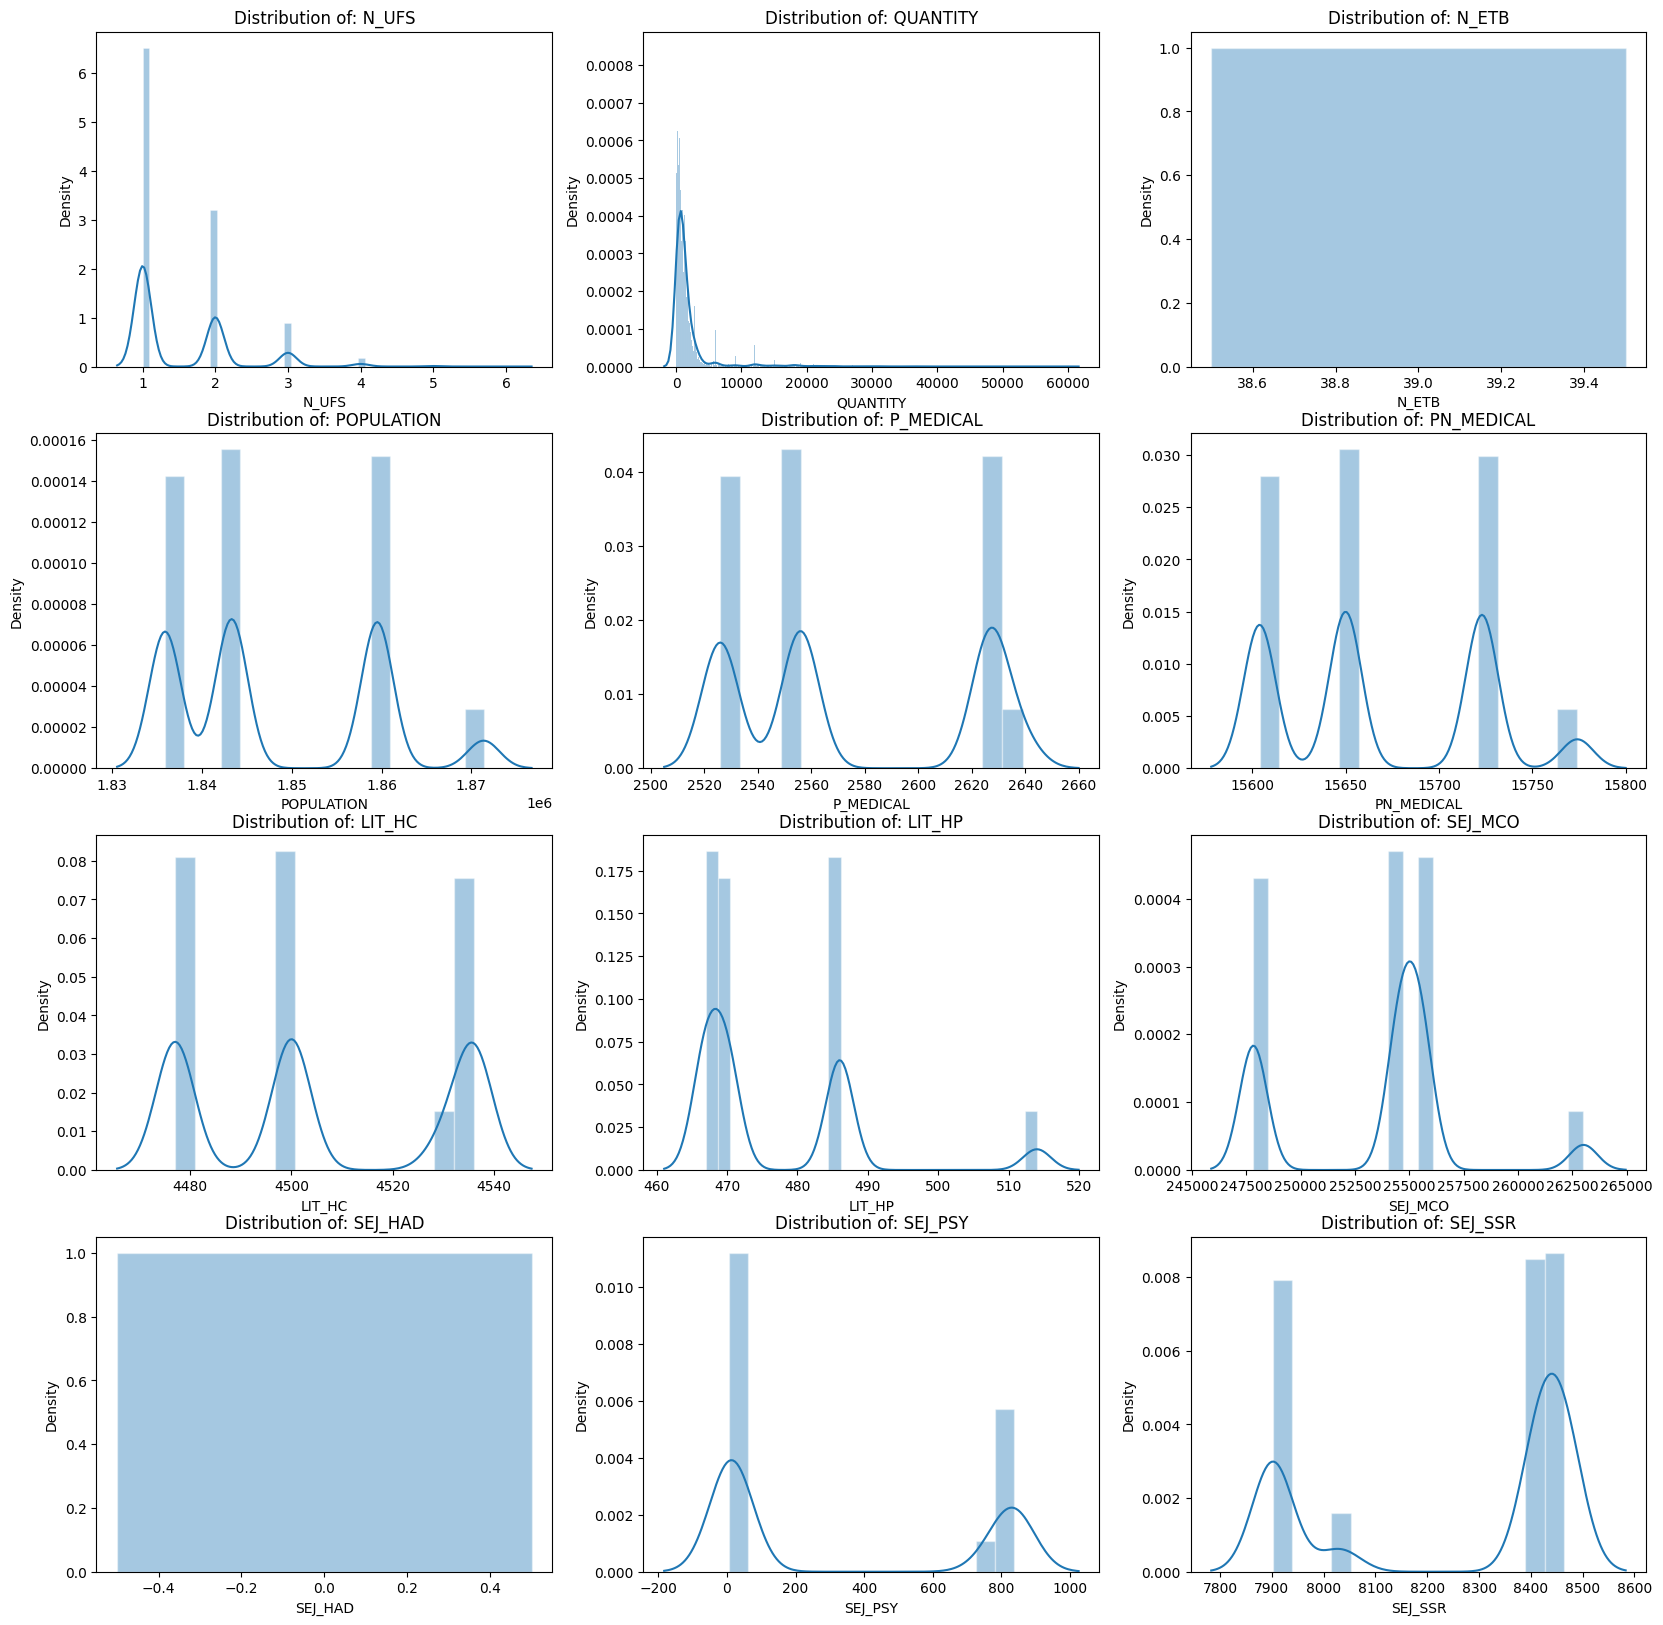

In [49]:
# Visualizing distribution before outlier removing
# Hospital 4
visualize_distribution(df_h4, numerical_features)

In [74]:

print("-"*100)
df_h1 = remove_outliers(df_h1, ["QUANTITY"], verbose = False)

print("-"*100)
df_h2 = remove_outliers(df_h2, ["QUANTITY"], verbose = False)

print("-"*100)
df_h3 = remove_outliers(df_h3, ["QUANTITY"], verbose = False)

print("-"*100)
df_h4 = remove_outliers(df_h4, ["QUANTITY"], verbose = False)


----------------------------------------------------------------------------------------------------
N:  22725
N_new:  22357
Total removed outliers: 1.62%
----------------------------------------------------------------------------------------------------
N:  15439
N_new:  15231
Total removed outliers: 1.35%
----------------------------------------------------------------------------------------------------
N:  27591
N_new:  27386
Total removed outliers: 0.743%
----------------------------------------------------------------------------------------------------
N:  9929
N_new:  9808
Total removed outliers: 1.22%


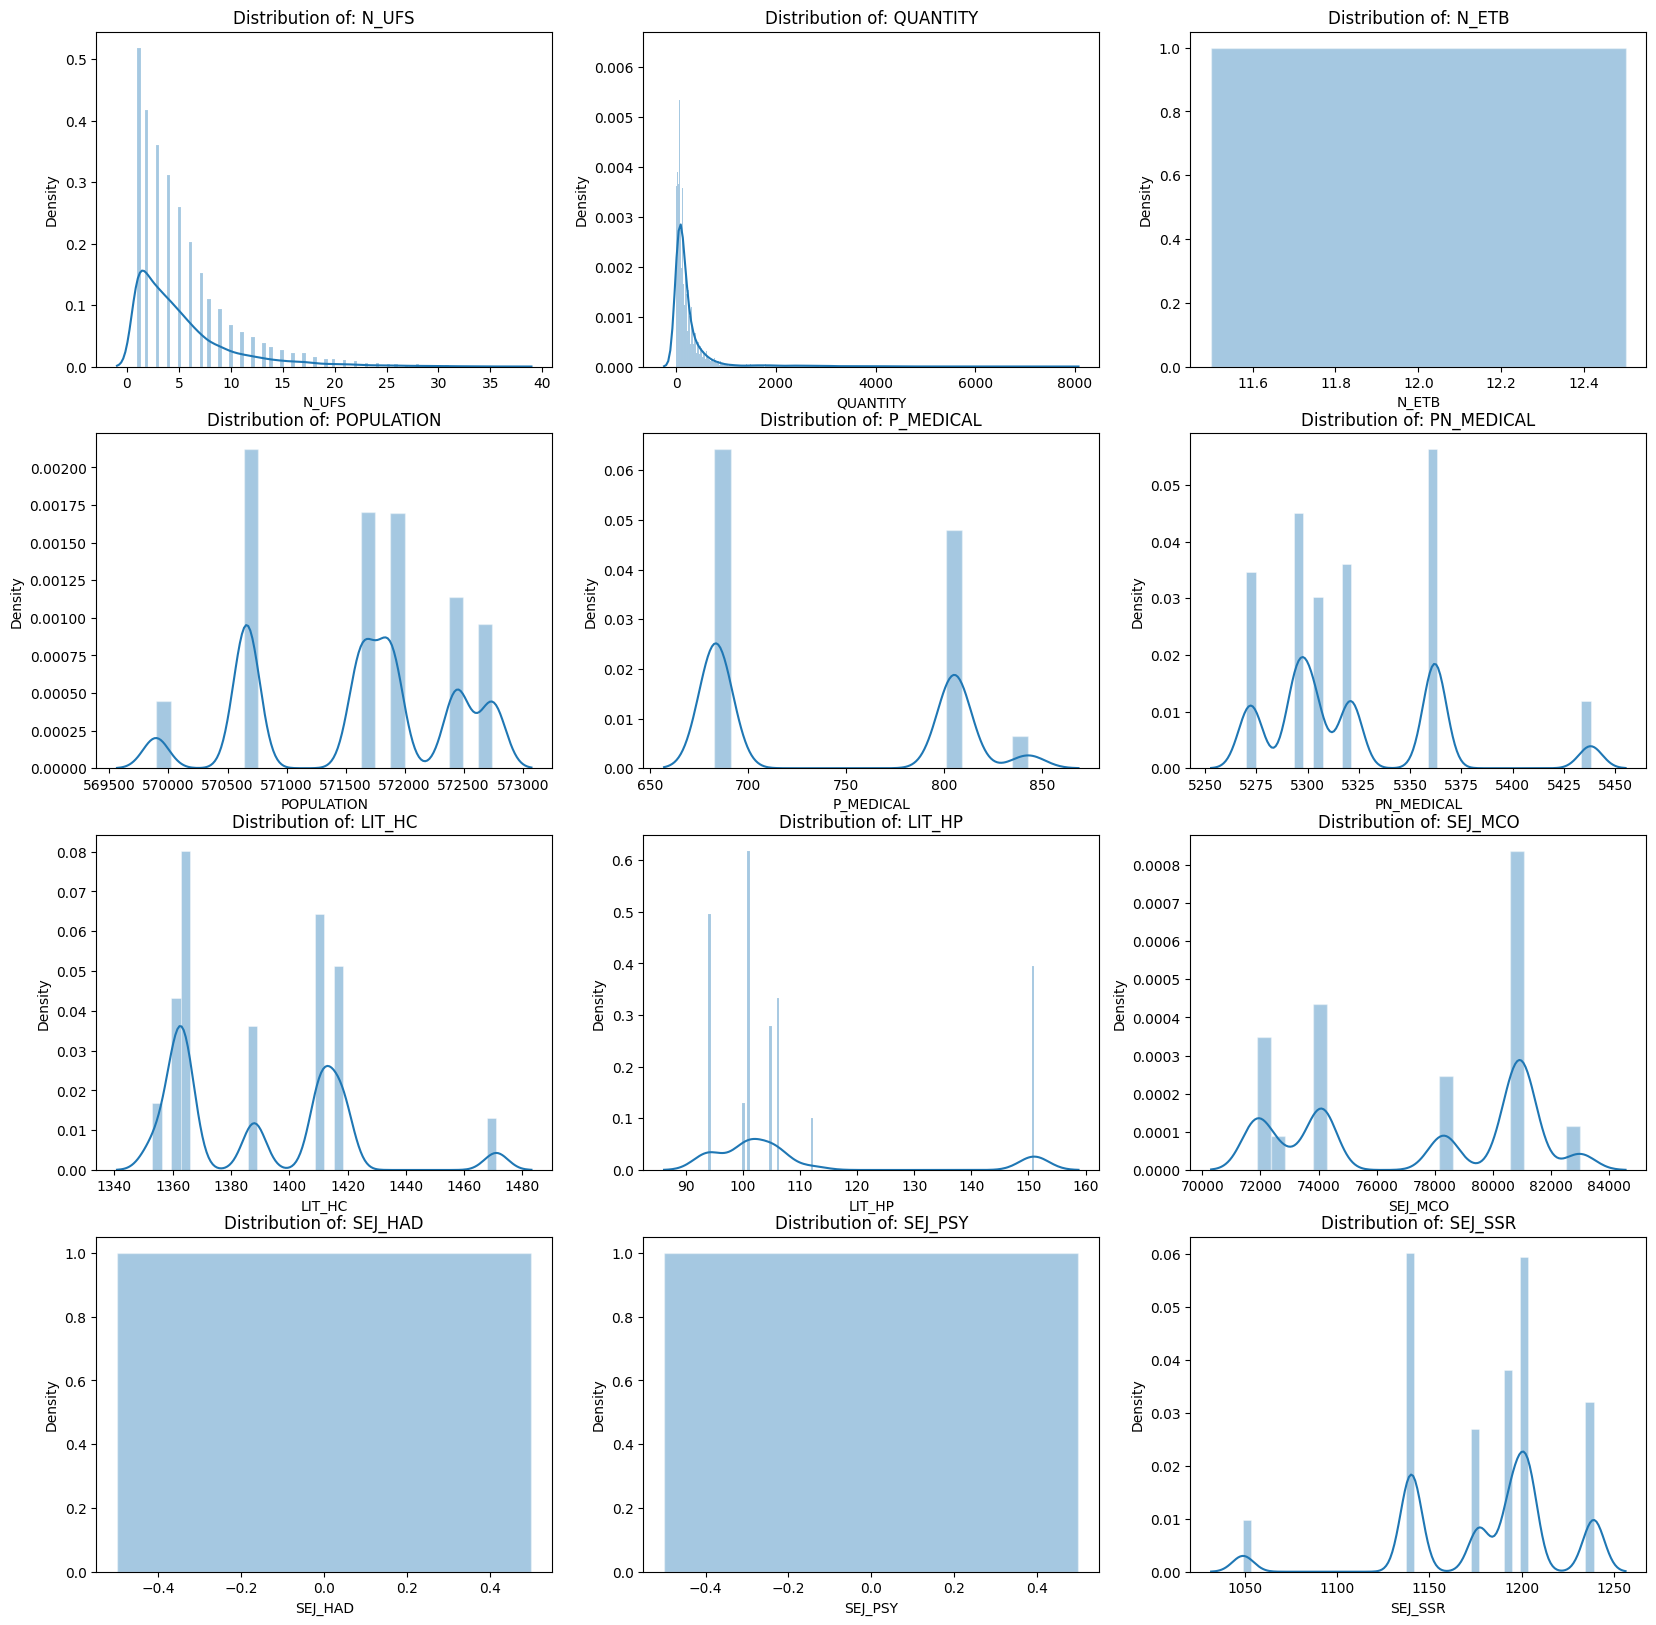

In [51]:
# Visualizing distribution after outlier removing
# Hospital 1
visualize_distribution(df_h1, numerical_features)

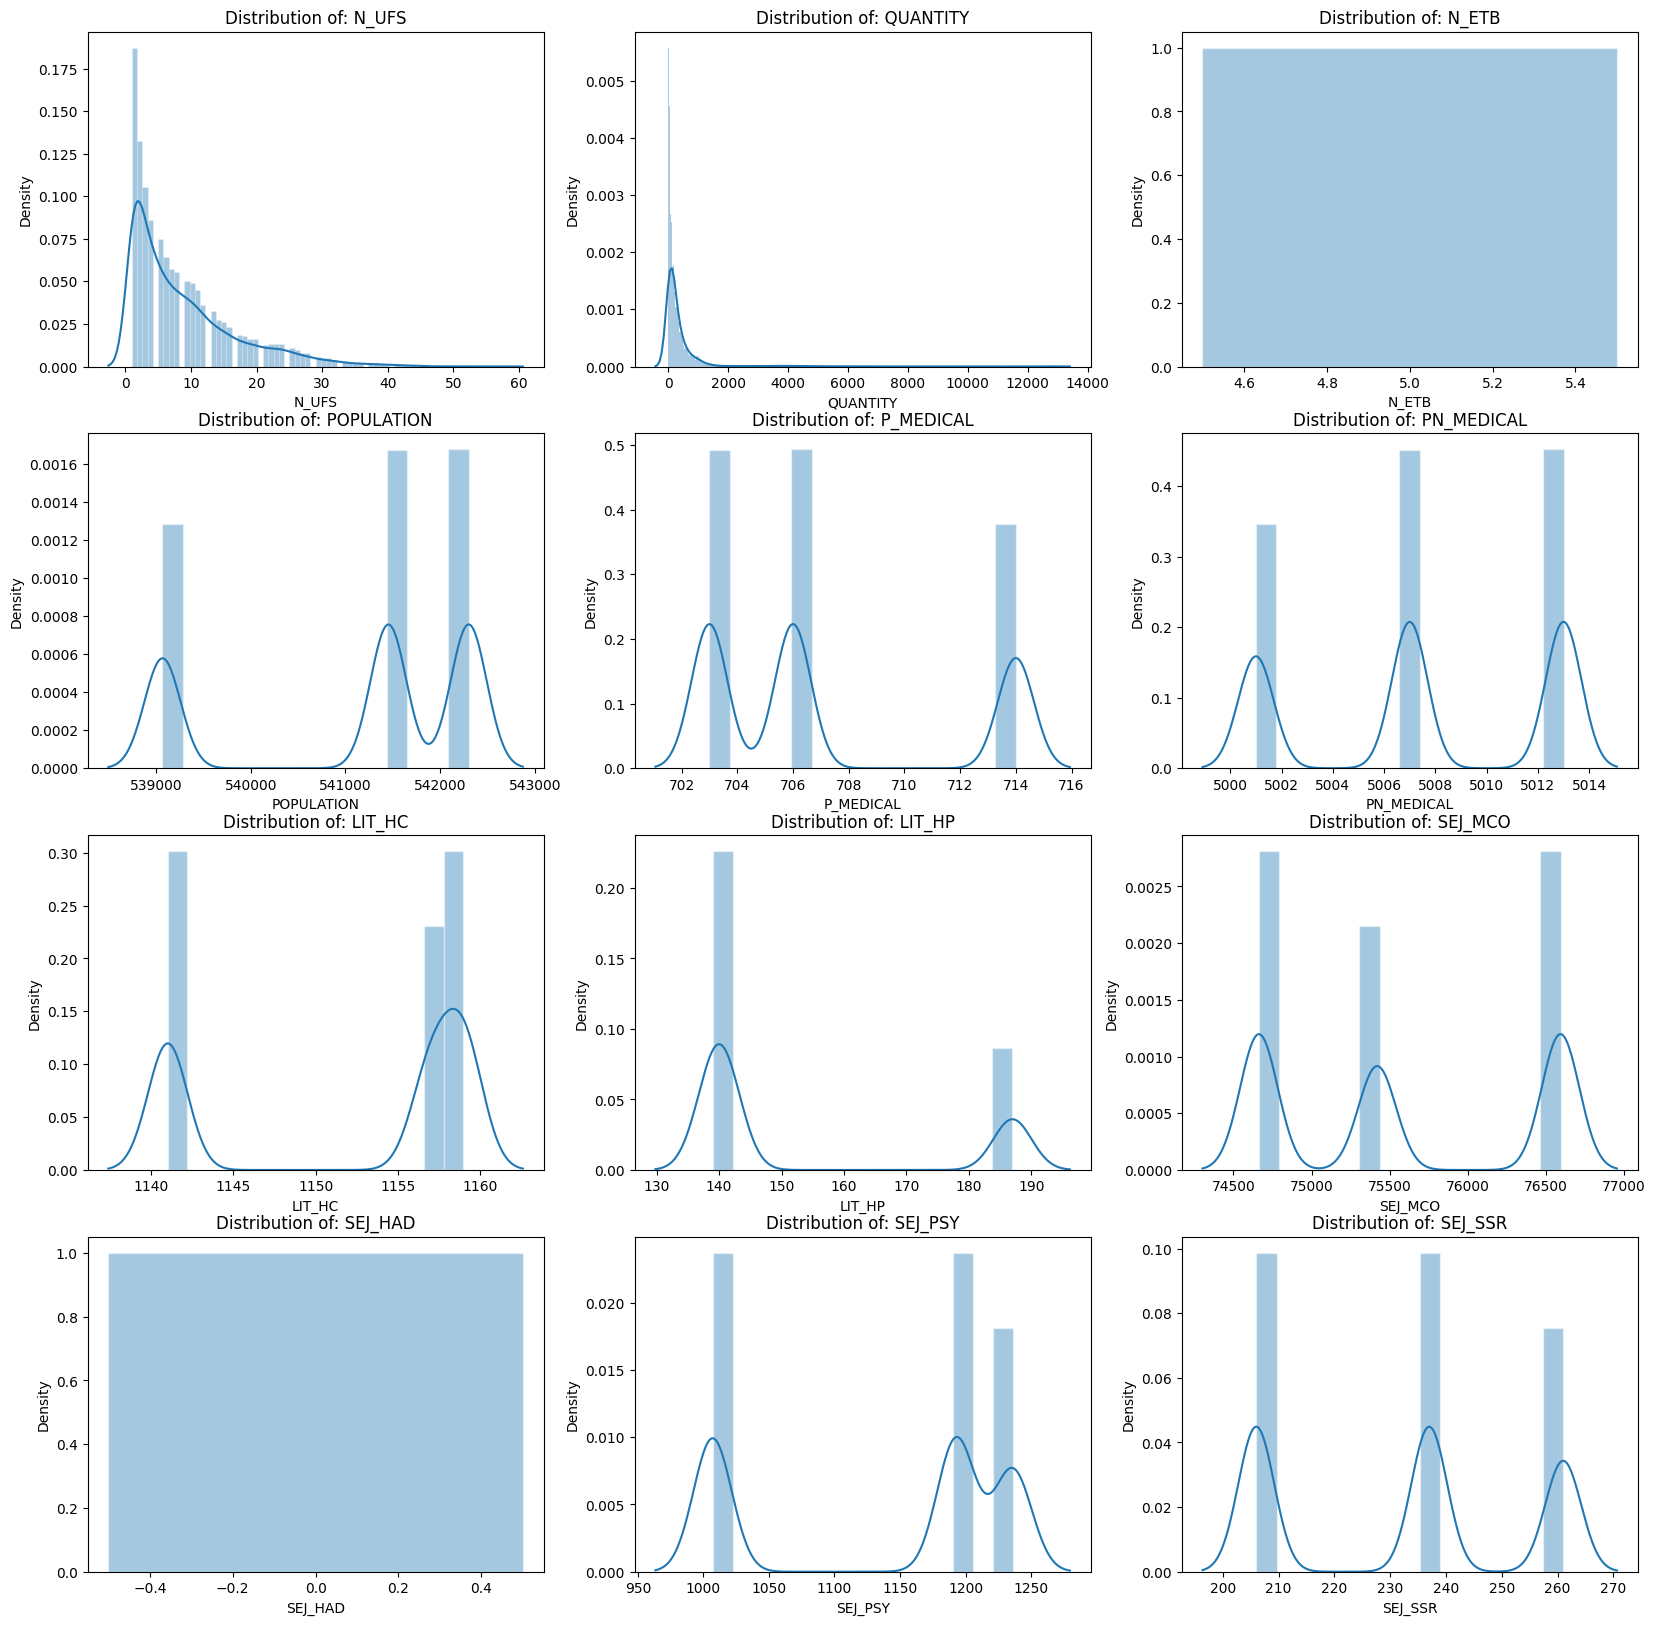

In [52]:
# Visualizing distribution after outlier removing
# Hospital 2
visualize_distribution(df_h2, numerical_features)

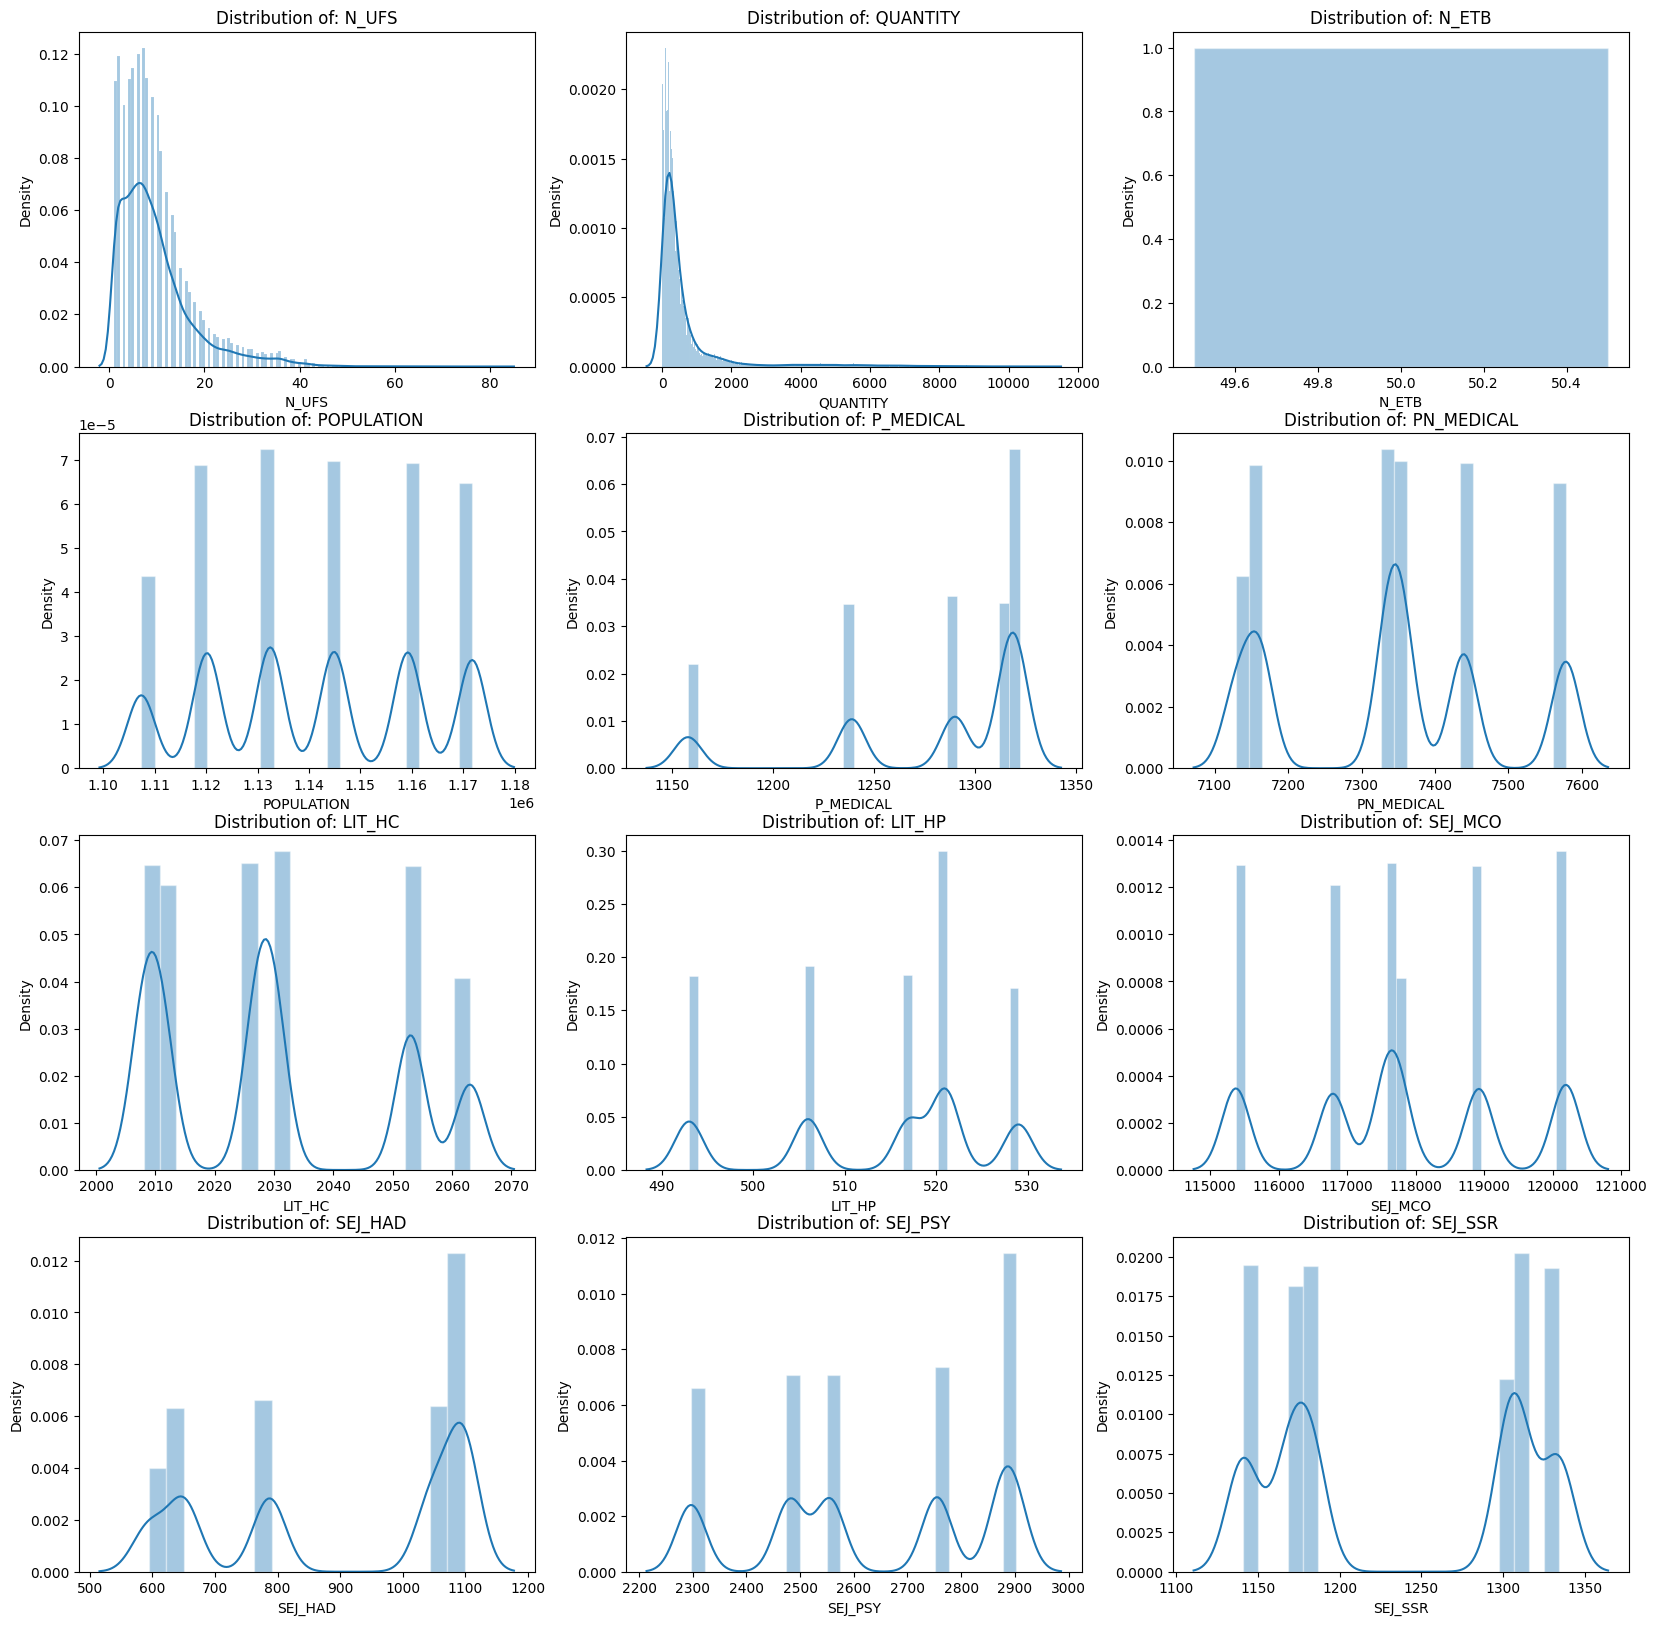

In [53]:
# Visualizing distribution after outlier removing
# Hospital 3
visualize_distribution(df_h3, numerical_features)

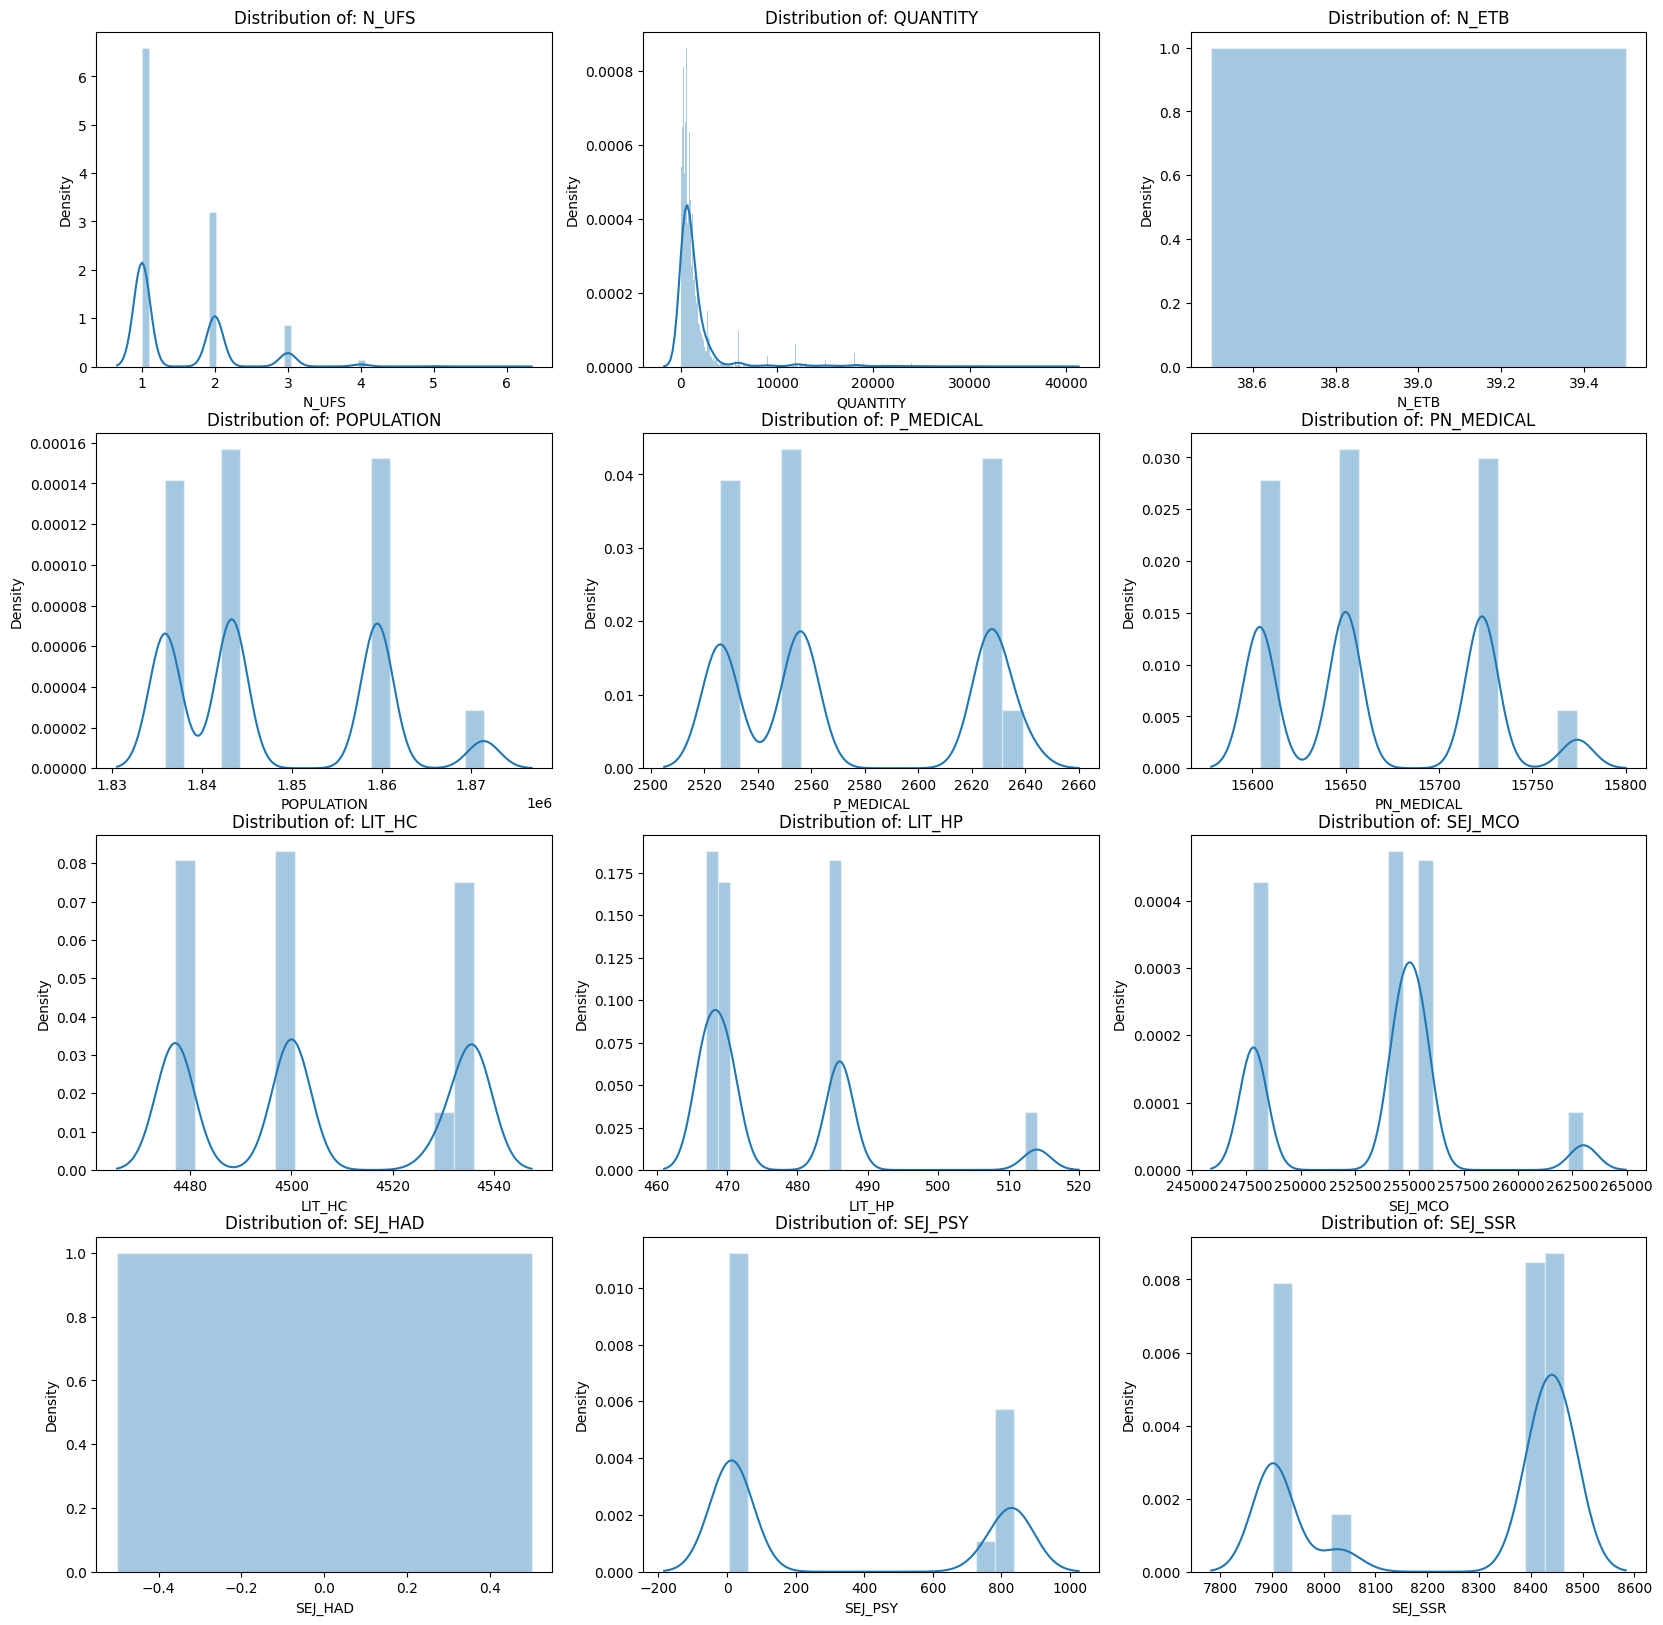

In [54]:
# Visualizing distribution after outlier removing
# Hospital 4
visualize_distribution(df_h4, numerical_features)

# Timeseries visualization

In [105]:
# Grouping the different datasets divided by hospital
df_grouped = pd.concat([df_h1, df_h2, df_h3, df_h4])
df_timeseries_plot = df_grouped.copy()

# Aggregating by "ID_REF", "YEAR", "MONTH", "ID_SITE_RATTACHE", summing the quantity
df_timeseries_plot = df_timeseries_plot.groupby(["ID_REF", "YEAR", "MONTH", "ID_SITE_RATTACHE"]).agg({
    'QUANTITY': 'sum',
    'CODE_ATC': 'first',
    'HOSPI_CODE_UCD': 'first',
    'N_UFS': 'first',
    'WEEK': 'first',
    'N_ETB': 'first',
    'POPULATION': 'first',
    'P_MEDICAL': 'first',
    'PN_MEDICAL': 'first',
    'LIT_HC': 'first',
    'LIT_HP': 'first',
    'SEJ_MCO': 'first',
    'SEJ_HAD': 'first',
    'SEJ_PSY': 'first',
    'SEJ_SSR': 'first',
    'SEJ_SLD': 'first'
}).reset_index()

# Creating the "DATE" column using "YEAR" and "MONTH" columns
df_timeseries_plot['DATE'] = pd.to_datetime(df_timeseries_plot[['YEAR', 'MONTH']].astype(str).agg('-'.join, axis=1), format='%Y-%m')
# Sorting by date and drug
df_timeseries_plot = df_timeseries_plot.sort_values(by=['DATE']).reset_index(drop=True)

df_timeseries_plot.drop(['YEAR', 'MONTH'], axis=1)

,ID_REF,ID_SITE_RATTACHE,QUANTITY,CODE_ATC,HOSPI_CODE_UCD,N_UFS,WEEK,N_ETB,POPULATION,P_MEDICAL,PN_MEDICAL,LIT_HC,LIT_HP,SEJ_MCO,SEJ_HAD,SEJ_PSY,SEJ_SSR,SEJ_SLD,DATE
0,830631,HOSPI_1,20.0,N05BA12,3400892075761,1,25.0,12,571675.0,683,5270,1471.0,112.0,72785,0,0,1049,109,2013-06-01
1,830303,HOSPI_1,10.0,N05CF01,3400891191226,1,25.0,12,571675.0,683,5270,1471.0,112.0,72785,0,0,1049,109,2013-06-01
2,890228,HOSPI_1,30.0,B01AC06,3400892065366,1,25.0,12,571675.0,683,5270,1471.0,112.0,72785,0,0,1049,109,2013-06-01
3,893880,HOSPI_1,20.0,A12BA01,3400891225037,1,25.0,12,571675.0,683,5270,1471.0,112.0,72785,0,0,1049,109,2013-06-01
4,820070,HOSPI_1,30.0,B01AB05,3400892669236,1,26.0,12,571675.0,683,5270,1471.0,112.0,72785,0,0,1049,109,2013-06-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4068,509929,HOSPI_3,140.0,R03AC02,3400892745848,2,49.0,50,1171739.0,1318,7578,2011.0,529.0,116793,1099,2297,1169,124,2019-12-01
4069,890264,HOSPI_1,30.0,N02AX02,3400892729589,1,49.0,12,569894.0,843,5438,1353.0,100.0,82997,0,0,1141,92,2019-12-01
4070,9276152,HOSPI_2,12800.0,B05XA03,3400892761527,17,49.0,5,542302.0,706,5013,1141.0,141.0,76593,0,1007,206,0,2019-12-01
4071,525057,HOSPI_3,9070.0,B05XA09,3400893826706,5,49.0,50,1171739.0,1318,7578,2011.0,529.0,116793,1099,2297,1169,124,2019-12-01


In [113]:
# Identifying a common period for the different timeseries
min_date_h1 = df_timeseries_plot[df_timeseries_plot["ID_SITE_RATTACHE"] == "HOSPI_1"]["DATE"].min()
min_date_h2 = df_timeseries_plot[df_timeseries_plot["ID_SITE_RATTACHE"] == "HOSPI_2"]["DATE"].min()
min_date_h3 = df_timeseries_plot[df_timeseries_plot["ID_SITE_RATTACHE"] == "HOSPI_3"]["DATE"].min()
min_date_h4 = df_timeseries_plot[df_timeseries_plot["ID_SITE_RATTACHE"] == "HOSPI_4"]["DATE"].min()

print(f'Min dates:' + f'\n H1: {min_date_h1}' + f'\n H2: {min_date_h2}' + f'\n H3: {min_date_h3}' + f'\n H4: {min_date_h4}')

max_date_h1 = df_timeseries_plot[df_timeseries_plot["ID_SITE_RATTACHE"] == "HOSPI_1"]["DATE"].max()
max_date_h2 = df_timeseries_plot[df_timeseries_plot["ID_SITE_RATTACHE"] == "HOSPI_2"]["DATE"].max()
max_date_h3 = df_timeseries_plot[df_timeseries_plot["ID_SITE_RATTACHE"] == "HOSPI_3"]["DATE"].max()
max_date_h4 = df_timeseries_plot[df_timeseries_plot["ID_SITE_RATTACHE"] == "HOSPI_4"]["DATE"].max()
print(f'\n Max dates:' + f'\n H1: {max_date_h1}' + f'\n H2: {max_date_h2}' + f'\n H3: {max_date_h3}' + f'\n H4: {max_date_h4}')

init = max(min_date_h1, min_date_h2, min_date_h3, min_date_h4)
ending = min(max_date_h1, max_date_h2, max_date_h3, max_date_h4)

print('\n')
print(f'Begin date: {init}')
print(f'End date: {ending}')


df_timeseries_plot = df_timeseries_plot[(df_timeseries_plot["DATE"]>= init)&(df_timeseries_plot["DATE"]<= ending)]
df_timeseries_plot.head()


Min dates:
 H1: 2013-06-01 00:00:00
 H2: 2017-03-01 00:00:00
 H3: 2014-05-01 00:00:00
 H4: 2016-01-01 00:00:00

 Max dates:
 H1: 2019-12-01 00:00:00
 H2: 2019-12-01 00:00:00
 H3: 2019-12-01 00:00:00
 H4: 2019-03-01 00:00:00


Begin date: 2017-03-01 00:00:00
End date: 2019-03-01 00:00:00


,ID_REF,YEAR,MONTH,ID_SITE_RATTACHE,QUANTITY,CODE_ATC,HOSPI_CODE_UCD,N_UFS,WEEK,N_ETB,...,P_MEDICAL,PN_MEDICAL,LIT_HC,LIT_HP,SEJ_MCO,SEJ_HAD,SEJ_PSY,SEJ_SSR,SEJ_SLD,DATE
1646,507071,2017,3,HOSPI_3,5785.0,H02AB06,3400892203645,5,9.0,50,...,1316,7356,2027.0,521.0,117583,1046,2556,1141,120,2017-03-01
1647,504495,2017,3,HOSPI_3,3880.0,N05BA12,3400892075761,10,9.0,50,...,1316,7356,2027.0,521.0,117583,1046,2556,1141,120,2017-03-01
1648,2463,2017,3,HOSPI_4,219700.0,N02BE01,3400891996128,1,9.0,39,...,2556,15650,4500.0,467.0,254570,0,5,8464,285,2017-03-01
1649,9122503,2017,3,HOSPI_2,80.0,A12BA01,3400891225037,2,13.0,5,...,714,5001,1157.0,187.0,75420,0,1236,261,0,2017-03-01
1650,507146,2017,3,HOSPI_3,13310.0,A12BA01,3400891225037,10,9.0,50,...,1316,7356,2027.0,521.0,117583,1046,2556,1141,120,2017-03-01


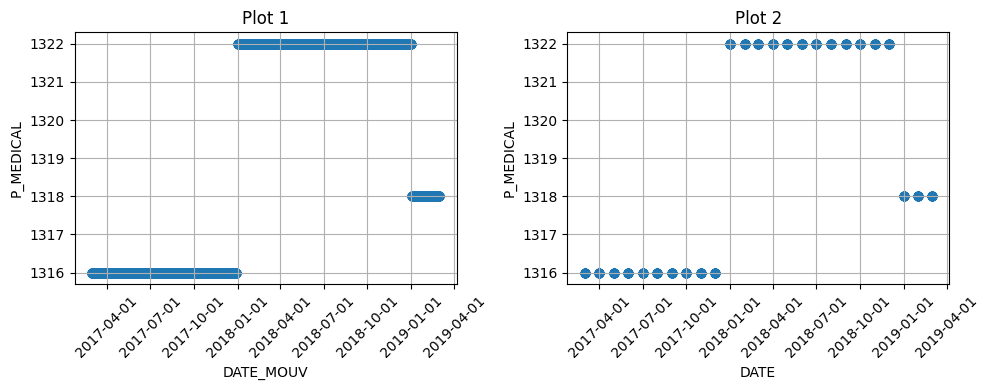

In [126]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))  # Create subplots with 1 row and 2 columns

# Plot 1
df_hospi_3 = df[(df["ID_SITE_RATTACHE"] == "HOSPI_3") & (df["DATE_MOUV"]>= init)&(df["DATE_MOUV"]<= ending)]
df_hospi_3 = df_hospi_3.sort_values(by=['DATE_MOUV']).reset_index(drop=True)
x = df_hospi_3["DATE_MOUV"]
y = df_hospi_3["P_MEDICAL"]
axs[0].scatter(x, y)
axs[0].set_xlabel('DATE_MOUV')
axs[0].set_ylabel('P_MEDICAL')
axs[0].set_title('Before aggregation')
axs[0].grid(True)  # Add grid
axs[0].set_xticks(axs[0].get_xticks())  # Set explicit x-axis tick locations
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45)  # Rotate x-axis ticks by 45 degrees

# Plot 2
df_hospi_3 = df_timeseries_plot[df_timeseries_plot["ID_SITE_RATTACHE"] == "HOSPI_3"]
x = df_hospi_3["DATE"]
y = df_hospi_3["P_MEDICAL"]
axs[1].scatter(x, y)
axs[1].set_xlabel('DATE')
axs[1].set_ylabel('P_MEDICAL')
axs[1].set_title('After aggregation')
axs[1].grid(True)  # Add grid
axs[1].set_xticks(axs[1].get_xticks())  # Set explicit x-axis tick locations
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45)  # Rotate x-axis ticks by 45 degrees

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()



In [127]:
df_timeseries_plot.to_csv('dataset_resampled.csv',
                          index=False)  